# Terrence Thesis - Case Study

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys

%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
numpy version: 1.14.5
matplotlib version: 2.2.2
flopy version: 3.2.9


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

In [7]:
nrow = 1
d = 10
ncol = 75 + d * 2
nlay = 10

Lx = 750 + 10 * d * 2
Ly = 25

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 20 + d, 23 + d ):
    top[ :, i ] = 31
for i in range ( 37 + d, 38 + d ):
    top[ :, i ] = 28
for j in range ( 40 + d, 55 + d ):
    top[ :, j ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 37 + d, 39 + d ):
    botm[ 0, :, i ] = 28
# N2 layer
for i in range ( 0, 36 + d ):
    botm[ 1, :, i ] = 24
for i in range ( 36 + d, 38 + d ):
    botm[ 1, :, i ] = 25
for i in range ( 38 + d, 57 + d ):
    botm[ 1, :, i ] = 26
for i in range ( 57 + d, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 23 + d ):
    botm[ 2, :, i ] = 20
for i in range ( 23 + d, 36 + d ):
    botm[ 2, :, i ] = 21.5
for i in range ( 36 + d, 38 + d ):
    botm[ 2, :, i ] = 24
for i in range ( 38 + d, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 37 + d ):
    botm[ 3, :, i ] = 17
for i in range ( 37 + d, 40 + d ):
    botm[ 3, :, i ] = 16
for i in range ( 40 + d, 50 + d ):
    botm[ 3, :, i ] = 15
for i in range ( 50 + d, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 40 + d ):
    botm[ 4, :, i ] = 15
for i in range ( 40 + d, 50 + d ):
    botm[ 4, :, i ] = 14
for i in range ( 50 + d, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 50 + d ):
    botm[ 5, :, i ] = 13
for i in range ( 50 + d, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 3521

perlen = 1
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True

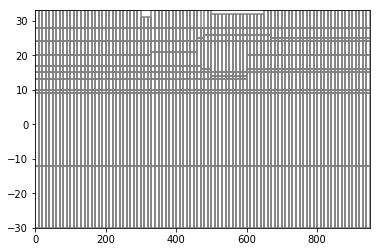

In [8]:
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=True
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 37 + d, 39 + d ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
strt[ 1, :, 1 ] = 28
strt[ 1, :, -1 ] = 28

for i in range ( 20 + d, 23 + d ):
    strt[ 0, :, i ] = 30
for j in range ( 40 + d, 55 + d ):
    strt[ 0, :, j ] = 30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [10]:
csv = pd.read_csv('SPA101.csv', delimiter=',')
chd_values = csv.iloc[ :, 2 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [11]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2.csv', delimiter=',' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3.csv', delimiter=',' ).iloc[ :, 1 ].values

for col in range ( 20 + d, 23 + d ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1450 ] )
    
for col in range ( 40 + d, 55 + d ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1500 ] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 20 + d, 23 + d ):
        sp[ stress_period ].append ( [ 0, 0, col, 29 + 2.5*bas3_data[ stress_period - 1 ], 1800 ] )
    for col in range ( 40 + d, 55 + d ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 5*bas12_data[ stress_period - 1 ], 2000 ] )

ghb = mf.ModflowGhb (tm, stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [12]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well.csv', delimiter=',').iloc[:, -2].values

spwell = {}
spwell[0] = [8, 0, 31 + d, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 31 + d, -wel_data[i-1]]

wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soilproperties and Flow-Package

In [13]:
k1 = 2   # fine sand 1.728-7.776
k2 = 34  # middle sand 7.776-34.56
k3 = 41  # stone 34.56-103.68
k4 = 1   # clay
k5 = 45  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range(20 + d, 50 + d):
    hk[2, :, i] = k3  # sand & stone
for i in range(45 + d, 57 + d):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range(20 + d, 34 + d):
    hk[4, :, i] = k3  # sand & stone
for i in range(34 + d, 38 + d):
    hk[4, :, i] = k4  # clay
for i in range(38 + d, 50 + d):
    hk[4, :, i] = k3  # sand & stone
for i in range(50 + d, 55 + d):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(26 + d, 40 + d):
    hk[5, :, i] = k6  # fine sand
for i in range(40 + d, 50 + d):
    hk[5, :, i] = k3  # sand & stone
for i in range(50 + d, 55 + d):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(26 + d, 40 + d):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2

# vertical HK
vk1 = 4
vk2 = 15
vk3 = 20
vk4 = 0.5
vk5 = 20
vk6 = 3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk3

# N1 layer
vka[0, :, :] = vk1  # fine sand

# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range(20 + d, 45 + d):
    vka[2, :, i] = vk3  # sand & stone
for i in range(45 + d, 57 + d):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range(20 + d, 34 + d):
    vka[4, :, i] = vk3  # sand & stone
for i in range(34 + d, 38 + d):
    vka[4, :, i] = vk4  # clay
for i in range(38 + d, 50 + d):
    vka[4, :, i] = vk3  # sand & stone
for i in range(50 + d, 55 + d):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range(26 + d, 40 + d):
    vka[5, :, i] = vk6  # fine sand
for i in range(40 + d, 50 + d):
    vka[5, :, i] = vk3  # sand & stone
for i in range(50 + d, 55 + d):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range(26 + d, 40 + d):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sy = 0.17
ss = 1e-4

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [14]:
budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['print head', 'print budget','print drawdown', 'save head', 'save budget','save drawdown'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (tm, rclose=1e-1)

### Write Model input and run the model

In [15]:
tm.write_input()
success, buff = tm.run_model()

FloPy is using the following executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/09/25 13:51:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water

 Solving:  Stress period:   103    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Wa

 Solving:  Stress period:   241    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     1    Ground-Wa

 Solving:  Stress period:   378    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:     1    Ground-Wa

 Solving:  Stress period:   485    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   488    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   489    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   490    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   491    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   494    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   495    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   497    Time step:     1    Ground-Wa

 Solving:  Stress period:   622    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   623    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   624    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   625    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   626    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   627    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   628    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   629    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   630    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   631    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   632    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   633    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     1    Ground-Wa

 Solving:  Stress period:   750    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   751    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   752    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   753    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   754    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   755    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   756    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   757    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   760    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   761    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   762    Time step:     1    Ground-Wa

 Solving:  Stress period:   876    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   877    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   878    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   879    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   880    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   881    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   882    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   883    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   884    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   885    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   886    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   887    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   888    Time step:     1    Ground-Wa

### Read Observations

In [16]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells
#well 157
ts1 = headobj.get_ts ( idx=(1, 0, 55 + d) )

# todo: implement HOB-Package